In [ ]:
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 KB 1.9 MB/s eta 0:00:00


In [ ]:
import os
import copy
import torch
import random
import librosa
import argparse
import torchaudio
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal
from torchaudio import transforms
import torchaudio.functional as F
from collections import namedtuple
from scipy.fft import fft, fftfreq
from audiomentations import (Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift,
SpecCompose, SpecChannelShuffle, SpecFrequencyMask)

# Load directory data
audio_files = glob('./*.wav')
label_files = glob('./*.csv')

# Load Audios
sr = 44100
audio_signals = {}
for audio_file in audio_files:
  audio_signals[(audio_file.split('/')[-1].split('.')[0].split(' ')[0])
                 ], _ = librosa.load(audio_file)

# Load Labels
gulp_data = pd.DataFrame()
for csv in (label_files):
  gulp_datum = pd.read_csv(csv)
  gulp_datum['audio'] = csv[2:4]
  gulp_datum[['start_min', 'start_sec', 'start_millisec']] = gulp_datum['start'].str.split('.', 2,expand=True)
  gulp_datum['total_start_sec'] = gulp_datum.start_min.astype(int) * 60 + gulp_datum.start_sec.astype(int) + gulp_datum.start_millisec.astype(int) / 1000
  gulp_datum[['stop_min', 'stop_sec', 'stop_millisec']] = gulp_datum['stop'].str.split('.', 2,expand=True)
  gulp_datum['total_stop_sec'] = gulp_datum.stop_min.astype(int) * 60 + gulp_datum.stop_sec.astype(int) + gulp_datum.stop_millisec.astype(int) / 1000
  gulp_data = gulp_data.append(gulp_datum)

def time_to_num(seconds = 0):
  return int(seconds * sr)

gulp_data['start_num'] = gulp_data.total_start_sec.apply(time_to_num).values
gulp_data['stop_num'] = gulp_data.total_stop_sec.apply(time_to_num).values

# Load Gulps
gulp_frames = []
for idx, row in gulp_data.iterrows():
  gulp_frames.append(audio_signals[row.audio][row.start_num:row.stop_num])


# Augmentation

# White noise addition
def add_white_noise(audio_signal, noise_factor):
    noise = np.random.normal(0, audio_signal.std(), audio_signal.size)
    augmented_signal = audio_signal + noise * noise_factor
    return augmented_signal

# Time Streching
def time_stretch(audio_signal, stretch_rate):
  if len(audio_signal) == 0: return []
  return librosa.effects.time_stretch(audio_signal, stretch_rate)

# Pitch Scaling
def pitch_scale(audio_signal, sr, num_semitones):
  return librosa.effects.pitch_shift(audio_signal, sr, num_semitones)

# Polarity Inversion
def invert_polarity(audio_signal):
  return audio_signal * -1

# Random Gain
def random_gain(audio_signal, min_gain_factor, max_gain_factor):
  gain_factor = random.uniform(min_gain_factor, max_gain_factor)
  return audio_signal * gain_factor


# Audiomentation Waveform
augment_waveform = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

# Audiomentation Spectogram
augment_spectogram = SpecCompose(
    [
        SpecChannelShuffle(p=0.5),
        SpecFrequencyMask(p=0.5),
    ]
)

# Torch audio signals
torch_audio_signals={}
for audio_file in audio_files:
  torch_audio_signals[audio_file[2:4]], sr=torchaudio.load(audio_file)

# Room reverb
effects=[
    ["lowpass", "-1", "300"],
    ["rate", f"{sr}"],
    ["reverb", "-w"],
]

# SpecAugment

# Frequency Masking
spectrogram=transforms.Spectrogram()
masking=transforms.FrequencyMasking(freq_mask_param=80)

# Time Masking
spectrogram=torchaudio.transforms.Spectrogram()
masking=torchaudio.transforms.TimeMasking(time_mask_param=80)

# Time Streching
spectrogram=torchaudio.transforms.Spectrogram()
stretch=torchaudio.transforms.TimeStretch()

# Apply augmentation

augmented_data={}

augmented_data['white_nose_low'] = []
augmented_data['white_nose_mid'] = []
augmented_data['white_nose_high'] = []
augmented_data['time_stretch_low'] = []
augmented_data['time_stretch_mid'] = []
augmented_data['time_stretch_high'] = []
augmented_data['pitch_scaling_low'] = []
augmented_data['pitch_scaling_mid'] = []
augmented_data['pitch_scaling_high'] = []
augmented_data['polarity_inverted'] = []
augmented_data['random_gain_low'] = []
augmented_data['random_gain_mid'] = []
augmented_data['random_gain_high'] = []
augmented_data['audiomentations_waveform'] = []
augmented_data['audiomentations_spectogram'] = []

for gulp_frame in gulp_frames:
    data=gulp_frame
    if len(data) < 100: continue

    # White noise
    augmented_data['white_nose_low'].append(add_white_noise(data, 0.1))
    augmented_data['white_nose_mid'].append(add_white_noise(data, 0.3))
    augmented_data['white_nose_high'].append(add_white_noise(data, 0.5))

    # Time Streching
    augmented_data['time_stretch_low'].append(time_stretch(data, 0.1))
    augmented_data['time_stretch_mid'].append(time_stretch(data, 0.3))
    augmented_data['time_stretch_high'].append(time_stretch(data, 0.5))

    # Pitch Scaling
    augmented_data['pitch_scaling_low'].append(pitch_scale(data, sr, 1))
    augmented_data['pitch_scaling_mid'].append(pitch_scale(data, sr, 2))
    augmented_data['pitch_scaling_high'].append(pitch_scale(data, sr, 2))

    # Polarity inversion
    augmented_data['polarity_inverted'].append(invert_polarity(data))

    # Random Gain
    augmented_data['random_gain_low'].append(random_gain(data, 0, 2))
    augmented_data['random_gain_mid'].append(random_gain(data, 2, 4))
    augmented_data['random_gain_high'].append(random_gain(data, 4, 6))

    # Audiomentation

    ## WaveForm
    augmented_data['audiomentations_waveform'].append(augment_waveform(samples=data, sample_rate=sr))

    ## Spectograph
    # spectrograph = np.abs(np.fft.fft(signal.hann(len(data)) * data))[:(len(data))//2]
    # augmented_data['audiomentations_spectogram'].append(augment_spectogram(spectrograph))


# Get non gulp data
non_gulp_data = []
start_space = 0
spacing = 25000
stop_space = start_space + spacing
number_of_gulp_samples_ex_per_signal = 100
for audio_signal_key in audio_signals.keys():
    for _ in range(number_of_gulp_samples_ex_per_signal):
        while len(gulp_data.loc[(gulp_data.audio=='s1') & (gulp_data.start_num
            <= start_space) & (gulp_data.stop_num >= stop_space)]) > 0:
            spacing = random.randint(10000, 25000);
            start_space = random.randint(0, len(audio_signals[audio_signal_key]) - spacing);
            stop_space = (start_space + spacing);
        non_gulp_data += (list(audio_signals[audio_signal_key][start_space:stop_space]))


# Get augmented gulp signals
segmented_augmented_gulp_signals = []
for augmented_data_key in augmented_data.keys():
    for val in augmented_data[augmented_data_key]:
        segmented_augmented_gulp_signals.append(val)

random.shuffle(segmented_augmented_gulp_signals)

temp_augmented_data = non_gulp_data
length_of_non_gulps = len(non_gulp_data)
for segmented_augmented_gulp_signal in segmented_augmented_gulp_signals:
    to_insert_idx = random.randint(0, length_of_non_gulps)
    temp_augmented_data.insert(to_insert_idx, list(segmented_augmented_gulp_signal))

buffer = 0
gulp_starts = []
gulp_stops = []
augmented_data = []
for idx in range(len(temp_augmented_data)):
    if type(temp_augmented_data[idx]) == float: augmented_data.append(temp_augmented_data[idx])
    elif type(temp_augmented_data[idx]) == list:
        gulp_starts.append(idx + buffer)
        buffer += len(temp_augmented_data[idx])
        gulp_stops.append(idx + buffer)
        augmented_data += temp_augmented_data[idx]
    else: augmented_data.append(temp_augmented_data[idx])

augmented_data_labels = pd.DataFrame()
augmented_data_labels["gulp_starts"] = gulp_starts
augmented_data_labels["gulp_stops"] = gulp_stops

In [ ]:
len(augmented_data_labels) * 25000

11550000

In [ ]:
(len(augmented_data_labels) * 2500000) / len(augmented_data)

50.50865053567594

In [ ]:
for idx in range(len(temp_augmented_data)):
    if type(temp_augmented_data[idx]) == float: augmented_data.append(temp_augmented_data[idx])
    elif type(temp_augmented_data[idx]) == list:
        gulp_starts.append(idx + buffer)
        buffer += len(temp_augmented_data[idx])
        gulp_stops.append(idx + buffer)
        augmented_data += temp_augmented_data[idx]
    else: 
      print(type(temp_augmented_data[idx]))
      break

<class 'numpy.float32'>


In [ ]:
type(list(audio_signals[audio_signal_key][start_space:stop_space].astype(float))[0])

numpy.float64

In [ ]:
non_gulp_cnt

NameError: ignored

In [ ]:
augmented_data_labels

gulp_starts  gulp_stops
0          55322       70580
1          87947      136897
2         156702      191188
3         195259      210826
4         274934      307304
..           ...         ...
457     22608009    22640379
458     22646516    22669492
459     22670821    22695296
460     22736636    22743692
461     22785174    22820939

[462 rows x 2 columns]

In [ ]:
type(temp_augmented_data[0])

numpy.float32

# Loading data and libraries

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
audio_files = glob('./*.wav')

In [ ]:
audio_files

['./s2 3.wav', './s3 3.wav', './s1 4.wav']

In [ ]:
audio_signals = {}
for audio_file in audio_files:
  audio_signals[audio_file[2:4]], sr = librosa.load(audio_file, sr=44100)

In [ ]:
print(f"Shape of s1: {audio_signals['s1'].shape}, time duration: {int(audio_signals['s1'].size / (sr * 60))} min {int((audio_signals['s1'].size / sr) % 60)} sec {int(((audio_signals['s1'].size / sr) * 1000) % 1000)} ms")
print(f"Shape of s2: {audio_signals['s2'].shape}, time duration: {int(audio_signals['s2'].size / (sr * 60))} min {int((audio_signals['s2'].size / sr) % 60)} sec {int(((audio_signals['s2'].size / sr) * 1000) % 1000)} ms")
print(f"Shape of s3: {audio_signals['s3'].shape}, time duration: {int(audio_signals['s3'].size / (sr * 60))} min {int((audio_signals['s3'].size / sr) % 60)} sec {int(((audio_signals['s3'].size / sr) * 1000) % 1000)} ms")
print(f"Sample Rate: {sr}")

Shape of s1: (4571137,), time duration: 1 min 43 sec 653 ms
Shape of s2: (6108160,), time duration: 2 min 18 sec 507 ms
Shape of s3: (4456449,), time duration: 1 min 41 sec 53 ms
Sample Rate: 44100


In [ ]:
gulp_data = pd.DataFrame()
for csv in glob('./*.csv'):
  gulp_datum = pd.read_csv(csv)
  gulp_datum['audio'] = csv[2:4]
  gulp_datum[['start_min', 'start_sec', 'start_millisec']] = gulp_datum['start'].str.split('.', 2,expand=True)
  gulp_datum['total_start_sec'] = gulp_datum.start_min.astype(int) * 60 + gulp_datum.start_sec.astype(int) + gulp_datum.start_millisec.astype(int) / 1000
  gulp_datum[['stop_min', 'stop_sec', 'stop_millisec']] = gulp_datum['stop'].str.split('.', 2,expand=True)
  gulp_datum['total_stop_sec'] = gulp_datum.stop_min.astype(int) * 60 + gulp_datum.stop_sec.astype(int) + gulp_datum.stop_millisec.astype(int) / 1000
  gulp_data = gulp_data.append(gulp_datum)
gulp_data

start      stop audio start_min start_sec start_millisec  \
0    0.8.322   0.8.903    s1         0         8            322   
1     0.9.36   0.9.557    s1         0         9             36   
2   0.11.459  0.11.619    s1         0        11            459   
3    0.13.41  0.13.533    s1         0        13             41   
4   0.13.792  0.14.039    s1         0        13            792   
..       ...       ...   ...       ...       ...            ...   
17  1.29.221  1.29.430    s2         1        29            221   
18  1.44.580  1.45.274    s2         1        44            580   
19  1.46.648  1.47.604    s2         1        46            648   
20  2.00.803  2.01.078    s2         2        00            803   
21  2.02.178  2.02.950    s2         2        02            178   

    total_start_sec stop_min stop_sec stop_millisec  total_stop_sec  
0             8.322        0        8           903           8.903  
1             9.036        0        9           557           9.557  
2            11.459        0       11           619          11.619  
3            13.041        0       13           533          13.533  
4            13.792        0       14           039          14.039  
..              ...      ...      ...           ...             ...  
17           89.221        1       29           430          89.430  
18          104.580        1       45           274         105.274  
19          106.648        1       47           604         107.604  
20          120.803        2       01           078         121.078  
21          122.178        2       02           950         122.950  

[70 rows x 11 columns]

In [ ]:
audio_signals = {}
for audio_file in audio_files:
  audio_signals[audio_file.split('SDR')[0].split('_')[-2]], sr = librosa.load(audio_file, sr=44100)

In [ ]:
gulp_data = pd.DataFrame()
for csv in glob('./*.csv'):
  gulp_datum = pd.read_csv(csv)
  gulp_datum['audio'] = csv.split('.')[0]
  gulp_datum['total_start_sec'] = gulp_datum.start.astype(float) 
  gulp_datum['total_stop_sec'] = gulp_datum.stop.astype(float) 
  gulp_data = gulp_data.append(gulp_datum)
gulp_data

start    stop audio  total_start_sec  total_stop_sec
0   0.909   1.015                  0.909           1.015
1   2.566   2.756                  2.566           2.756
2   4.581   4.673                  4.581           4.673
3   6.660   6.759                  6.660           6.759
0   1.791   2.104                  1.791           2.104
1   3.907   4.063                  3.907           4.063
2   5.586   5.933                  5.586           5.933
3   6.840   6.985                  6.840           6.985
4   8.328   8.541                  8.328           8.541
0   1.552   1.768                  1.552           1.768
1   6.802   6.931                  6.802           6.931
2   8.289   8.516                  8.289           8.516
3  10.682  10.833                 10.682          10.833
0   2.338   2.687                  2.338           2.687
1   7.214   7.383                  7.214           7.383
2   9.980  10.279                  9.980          10.279
0   3.761   4.040                  3.761           4.040
1   5.622   5.781                  5.622           5.781
2   6.607   6.716                  6.607           6.716
3   7.602   7.741                  7.602           7.741
0   0.779   0.954                  0.779           0.954
1   2.612   2.861                  2.612           2.861
2   4.983   5.158                  4.983           5.158
3   6.857   6.982                  6.857           6.982
4   8.615   8.731                  8.615           8.731

In [ ]:
sr=44100
def time_to_num(seconds = 0):
  return int((seconds) * sr)

In [ ]:
gulp_data['start_num'] = gulp_data.total_start_sec.apply(time_to_num).values
gulp_data['stop_num'] = gulp_data.total_stop_sec.apply(time_to_num).values

In [ ]:
start_space = 367000
stop_space = 392622

gulp_data.loc[(gulp_data.audio=='s1') & (gulp_data.start_num <= start_space) & (gulp_data.stop_num >= stop_space)]

Empty DataFrame
Columns: [start, stop, audio, total_start_sec, total_stop_sec, start_num, stop_num]
Index: []

In [ ]:
gulp_data

start    stop audio  total_start_sec  total_stop_sec  start_num  stop_num
0   0.909   1.015                  0.909           1.015      40086     44761
1   2.566   2.756                  2.566           2.756     113160    121539
2   4.581   4.673                  4.581           4.673     202022    206079
3   6.660   6.759                  6.660           6.759     293706    298071
0   1.791   2.104                  1.791           2.104      78983     92786
1   3.907   4.063                  3.907           4.063     172298    179178
2   5.586   5.933                  5.586           5.933     246342    261645
3   6.840   6.985                  6.840           6.985     301644    308038
4   8.328   8.541                  8.328           8.541     367264    376658
0   1.552   1.768                  1.552           1.768      68443     77968
1   6.802   6.931                  6.802           6.931     299968    305657
2   8.289   8.516                  8.289           8.516     365544    375555
3  10.682  10.833                 10.682          10.833     471076    477735
0   2.338   2.687                  2.338           2.687     103105    118496
1   7.214   7.383                  7.214           7.383     318137    325590
2   9.980  10.279                  9.980          10.279     440118    453303
0   3.761   4.040                  3.761           4.040     165860    178164
1   5.622   5.781                  5.622           5.781     247930    254942
2   6.607   6.716                  6.607           6.716     291368    296175
3   7.602   7.741                  7.602           7.741     335248    341378
0   0.779   0.954                  0.779           0.954      34353     42071
1   2.612   2.861                  2.612           2.861     115189    126170
2   4.983   5.158                  4.983           5.158     219750    227467
3   6.857   6.982                  6.857           6.982     302393    307906
4   8.615   8.731                  8.615           8.731     379921    385037

In [ ]:
len(gulp_data)

25

In [ ]:
def time_to_num(minutes = 0, seconds = 0):
  return int(((minutes * 60) + seconds) * sr)

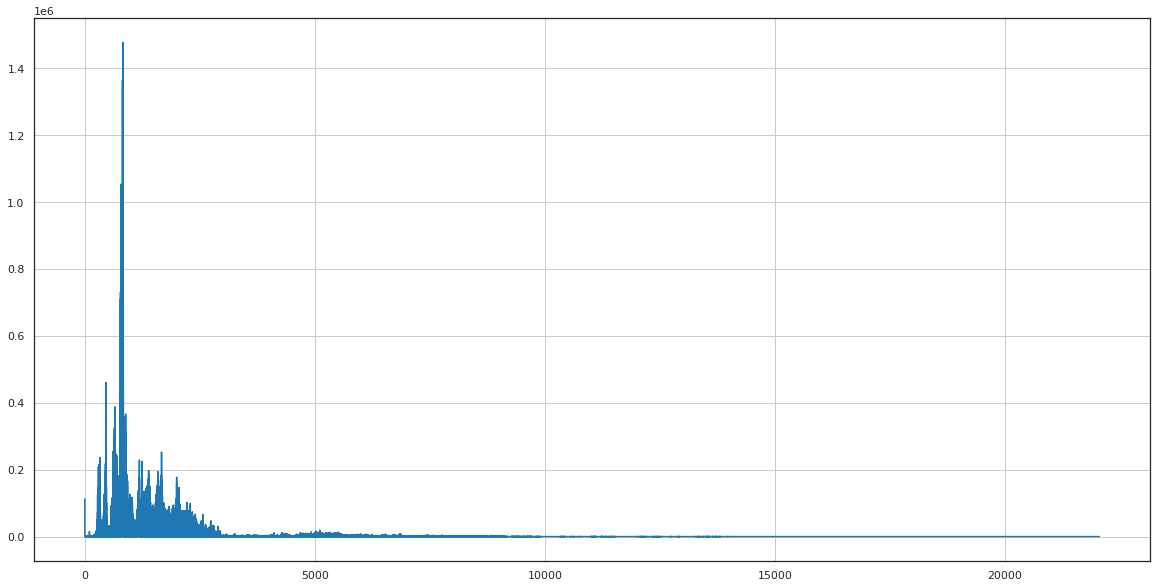

In [ ]:
N = len(audio_signals['s1'])
yf = np.abs(np.fft.fft(audio_signals['s1'])) ** 2

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0, sr, N)[:N//2], yf[:N//2])
plt.grid()
plt.show()


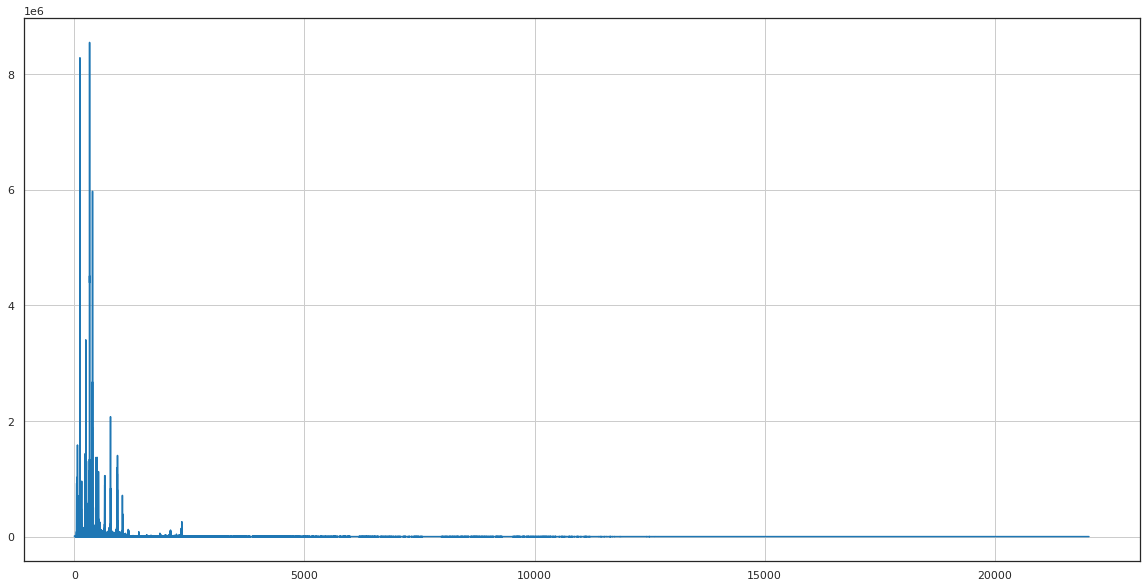

In [ ]:
N = len(audio_signals['s2'])
yf = np.abs(np.fft.fft(audio_signals['s2'])) ** 2

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0, sr, N)[:N//2], yf[:N//2])
plt.grid()
plt.show()


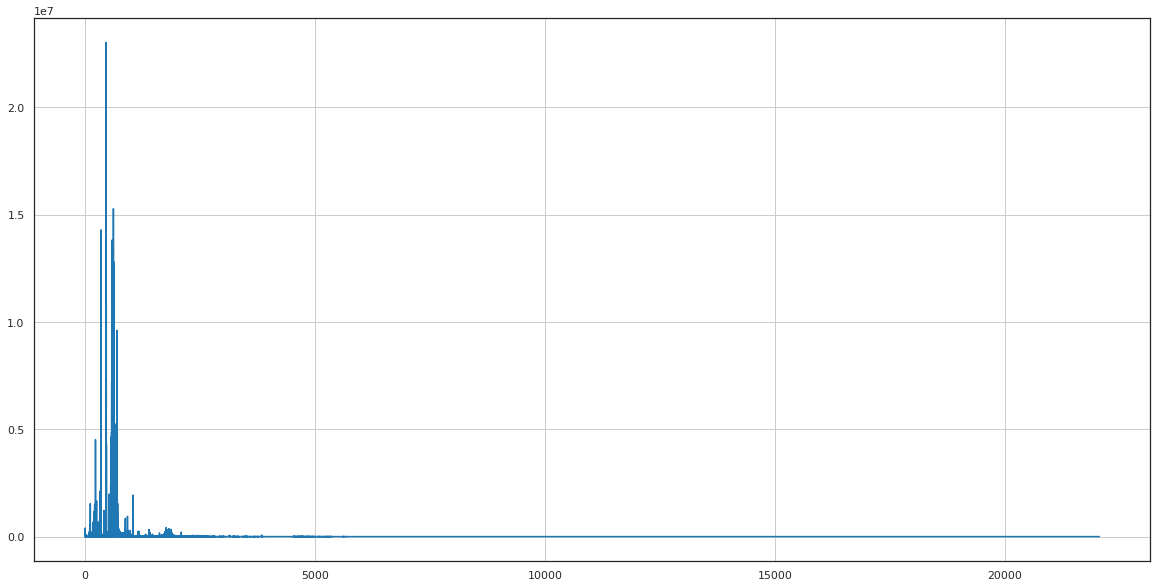

In [ ]:
N = len(audio_signals['s3'])
yf = np.abs(np.fft.fft(audio_signals['s3'])) ** 2

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(np.linspace(0, sr, N)[:N//2], yf[:N//2])
plt.grid()
plt.show()


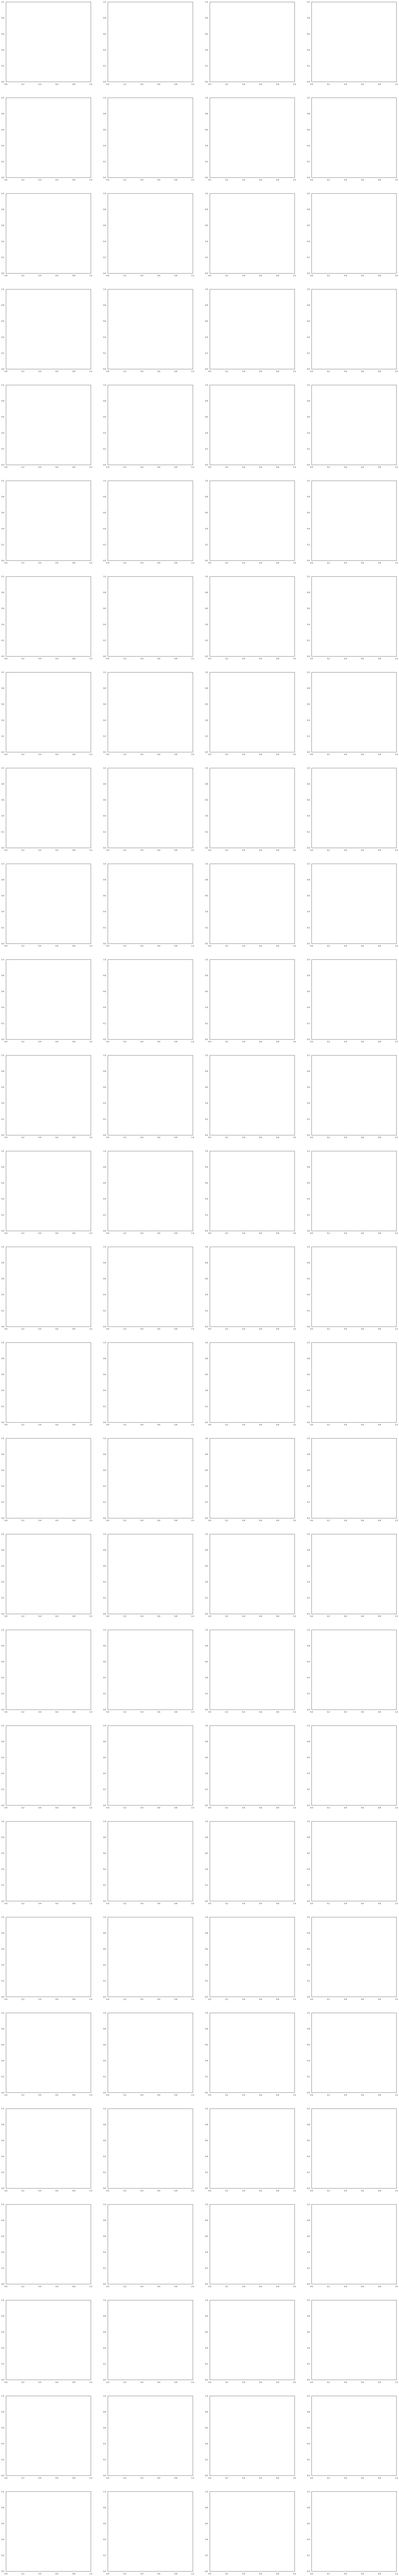

In [ ]:
figure, axis = plt.subplots(27, 4, figsize=(40, 270))
padding_in_ms = 0.1

data_orig_lens = []
data_orig_mins = []
data_orig_maxs = []
data_orig_means = []
data_orig_medians = []
data_orig_stds = []
data_orig_ptps = []

for idx, row in tqdm(gulp_data.iterrows()):
  data_orig = y[time_to_num(seconds=row.total_start_sec): time_to_num(seconds=row.total_stop_sec)]

  data_orig_lens.append(len(data_orig))
  data_orig_mins.append(np.amin(data_orig))
  data_orig_maxs.append(np.amax(data_orig))
  data_orig_means.append(np.mean(data_orig))
  data_orig_medians.append(np.median(data_orig))
  data_orig_stds.append(np.std(data_orig))
  data_orig_ptps.append(np.ptp(data_orig))

  pad_start = time_to_num(seconds=row.total_start_sec-padding_in_ms) if time_to_num(seconds=row.total_start_sec-padding_in_ms) > 0 else 0
  pad_stop = time_to_num(seconds=row.total_stop_sec+padding_in_ms) if time_to_num(seconds=row.total_stop_sec+padding_in_ms) < len(y) else len(y)
  data_pad = y[(pad_start): (pad_stop)]
  axis[idx, 0].plot(range(0, len(data_orig)), data_orig)
  axis[idx, 0].set_title(f"Gulp Ranging from {row.total_start_sec} to {row.total_stop_sec}")
  axis[idx, 1].plot(range(0, len(data_pad)), data_pad)
  axis[idx, 1].set_title(f"Padded Gulp Ranging from {row.total_start_sec+padding_in_ms} to {row.total_stop_sec-padding_in_ms}")

  N = (len(data_orig))  # number of sample points
  yf = np.fft.fft(signal.hann(N) * data_orig)
  xf = np.linspace(0, sr, N)[:N//2]
  axis[idx, 2].plot(xf, np.abs(yf[0:N//2]))
  axis[idx, 2].set_title(f"Frequency Gulp Ranging from {row.total_start_sec+padding_in_ms} to {row.total_stop_sec-padding_in_ms}")

  N = (len(data_pad))  # number of sample points
  yf = np.fft.fft(data_pad * signal.hann(N))
  xf = np.linspace(0, sr, N)[:N//2]
  axis[idx, 3].plot(xf, np.abs(yf[0:N//2]))
  axis[idx, 3].set_title(f"Frequency Padded Gulp Ranging from {row.total_start_sec+padding_in_ms} to {row.total_stop_sec-padding_in_ms}")

plt.show()

In [ ]:
gulp_analysis = pd.DataFrame()
gulp_analysis['data_orig_len'] = data_orig_lens
gulp_analysis['data_orig_min'] = data_orig_mins
gulp_analysis['data_orig_max'] = data_orig_maxs
gulp_analysis['data_orig_mean'] = data_orig_means
gulp_analysis['data_orig_median'] = data_orig_medians
gulp_analysis['data_orig_std'] = data_orig_stds
gulp_analysis['data_orig_ptp'] = data_orig_ptps
gulp_analysis.head()

Empty DataFrame
Columns: [data_orig_len, data_orig_min, data_orig_max, data_orig_mean, data_orig_median, data_orig_std, data_orig_ptp]
Index: []

In [ ]:
gulp_analysis.describe()

# Time Domain Feature selection and Frequency Domain feature selection

In [ ]:
def num_to_sec(num):
  return num / sr

In [ ]:
print(f"Average gulp sound duration in ms: {round(1/sr * 4841.148148 * 1000, 2)}ms")
print(f"Max gulp sound duration in ms: {round(1/sr * 21256.000000 * 1000, 2)}ms")
print(f"Min gulp sound duration in ms: {round(1/sr * 1631.000000 * 1000, 2)}ms")
print(f"75% quartile gulp sound duration in ms: {round(1/sr * 3947.000000 * 1000, 2)}ms")
print(f"50% quartile gulp sound duration in ms: {round(1/sr * 2977.000000 * 1000, 2)}ms")
print(f"25% quartile gulp sound duration in ms: {round(1/sr * 2315.000000 * 1000, 2)}ms")
print(f"Standard deviation in gulp sound duration in ms: {round(1/sr * 4680.805944 * 1000, 2)}ms")

Average gulp sound duration in ms: 109.78ms
Max gulp sound duration in ms: 482.0ms
Min gulp sound duration in ms: 36.98ms
75% quartile gulp sound duration in ms: 89.5ms
50% quartile gulp sound duration in ms: 67.51ms
25% quartile gulp sound duration in ms: 52.49ms
Standard deviation in gulp sound duration in ms: 106.14ms


In [ ]:
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal


frame_time = 16
frame_size = int(sr * frame_time / 1000)

overlap_per = 50
overlap_time = frame_time * overlap_per / 100
overlap = int(frame_size * overlap_per / 100)

print(f"Frame size: {frame_size}")
print(f"Frame time in milliseconds: {frame_time}ms")

print(f"Overlap time in milliseconds: {overlap_time}")
print(f"Overlap size: {overlap}")

# Statistical Features- time
time_frame_data_mins = []
time_frame_data_maxs = []
time_frame_data_means = []
time_frame_data_medians = []
time_frame_data_stds = []
time_frame_data_ptps = []

# Time domain features
amplitude_evelopes = []
root_mean_square_energies = []
zero_crossing_rates = []

# Statistical Features- freq
freq_magnitude_prod_frame_data_mins = []
freq_magnitude_prod_frame_data_maxs = []
freq_magnitude_prod_frame_data_means = []
freq_magnitude_prod_frame_data_medians = []
freq_magnitude_prod_frame_data_stds = []
freq_magnitude_prod_frame_data_ptps = []

# Frequency domain features
split_frequency = 1500
band_energy_ratios = []
spectral_centroids = []
bandwidths = []

# Gulp Data
gulp_constituencies = []

# Audio Metadata
audio_name = []

for audio_signal in audio_signals.keys():
  print(f'Processing audio signal file: {audio_signal}')
  y = audio_signals[audio_signal]
  for start in tqdm(range(0, len(y), overlap)):

    # Getting Frame
    stop = (start + frame_size) if (start + frame_size) < len(y) else (len(y) - 1)
    time_frame_data = y[start:stop]
    if (stop - start) < overlap: break

    # Time based Statistical Features
    time_frame_data_mins.append(np.amin(time_frame_data))
    time_frame_data_maxs.append(np.amax(time_frame_data))
    time_frame_data_means.append(np.mean(time_frame_data))
    time_frame_data_medians.append(np.median(time_frame_data))
    time_frame_data_stds.append(np.std(time_frame_data))
    time_frame_data_ptps.append(np.ptp(time_frame_data))
    
    # Time domain features
    amplitude_evelopes.append(np.amax(time_frame_data))
    root_mean_square_energies.append(np.sqrt(np.mean(time_frame_data**2)))
    zero_crossing_rates.append(0.5 * np.sum([np.abs(np.sign(time_frame_data[idx]) - np.sign(time_frame_data[idx + 1])) for idx in range(len(time_frame_data) - 1)]))

    # Fourier transform with hann windowing
    N = (len(time_frame_data))
    yf = np.abs(np.fft.fft(signal.hann(N) * time_frame_data)) [:N//2]
    xf = np.linspace(0, sr, N)[:N//2]

    # Frequency based Statistical Features
    freq_magnitude_prod_frame_data = xf * yf
    freq_magnitude_prod_frame_data_mins.append(np.amin(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_maxs.append(np.amax(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_means.append(np.mean(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_medians.append(np.median(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_stds.append(np.std(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_ptps.append(np.ptp(freq_magnitude_prod_frame_data))

    # Frequency domain features
    band_energy_ratios.append(np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / np.sum(yf[int(split_frequency* (N / sr)):] ** 2))
    spectral_centroids.append(np.sum(yf * xf) / np.sum(yf))
    bandwidths.append(np.sum((xf - (np.sum(yf * xf) / np.sum(yf))) * yf) / np.sum(yf))

    # Gulp Data
    gulp_constituencies.append(int(len(gulp_data.loc[(gulp_data.audio == audio_signal) & (gulp_data.total_start_sec <= num_to_sec(start)) & (gulp_data.total_stop_sec >= num_to_sec(stop))]) > 0))

    # Audio Metadata
    audio_name.append(audio_signal)

# Dataframe initialization
gulp_analysis = pd.DataFrame()

# Statistical Features- time
gulp_analysis['time_frame_data_mins'] = time_frame_data_mins
gulp_analysis['time_frame_data_maxs'] = time_frame_data_maxs
gulp_analysis['time_frame_data_means'] = time_frame_data_means
gulp_analysis['time_frame_data_medians'] = time_frame_data_medians
gulp_analysis['time_frame_data_stds'] = time_frame_data_stds
gulp_analysis['time_frame_data_ptps'] = time_frame_data_ptps

# Time domain features
gulp_analysis['amplitude_evelopes'] = amplitude_evelopes
gulp_analysis['root_mean_square_energies'] = root_mean_square_energies
gulp_analysis['zero_crossing_rates'] = zero_crossing_rates

# Statistical Features- freq
gulp_analysis['freq_magnitude_prod_frame_data_mins'] = freq_magnitude_prod_frame_data_mins
gulp_analysis['freq_magnitude_prod_frame_data_maxs'] = freq_magnitude_prod_frame_data_maxs
gulp_analysis['freq_magnitude_prod_frame_data_means'] = freq_magnitude_prod_frame_data_means
gulp_analysis['freq_magnitude_prod_frame_data_medians'] = freq_magnitude_prod_frame_data_medians
gulp_analysis['freq_magnitude_prod_frame_data_stds'] = freq_magnitude_prod_frame_data_stds
gulp_analysis['freq_magnitude_prod_frame_data_ptps'] = freq_magnitude_prod_frame_data_ptps

# Frequency domain features
gulp_analysis['band_energy_ratios'] = band_energy_ratios
gulp_analysis['spectral_centroids'] = spectral_centroids
gulp_analysis['bandwidths'] = bandwidths

# Gulp Data
gulp_analysis['gulp_constituencies'] = gulp_constituencies

# Audio Metadata
gulp_analysis['audio_name'] = audio_name

# Dataframe
gulp_analysis.describe()

Frame size: 705
Frame time in milliseconds: 16ms
Overlap time in milliseconds: 8.0
Overlap size: 352
Processing audio signal file: s2


  0%|          | 0/17353 [00:00<?, ?it/s]<ipython-input-71-7d7a17f1d4b2>:90: RuntimeWarning: invalid value encountered in double_scalars
  band_energy_ratios.append(np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / np.sum(yf[int(split_frequency* (N / sr)):] ** 2))
<ipython-input-71-7d7a17f1d4b2>:91: RuntimeWarning: invalid value encountered in double_scalars
  spectral_centroids.append(np.sum(yf * xf) / np.sum(yf))
<ipython-input-71-7d7a17f1d4b2>:92: RuntimeWarning: invalid value encountered in double_scalars
  bandwidths.append(np.sum((xf - (np.sum(yf * xf) / np.sum(yf))) * yf) / np.sum(yf))
100%|█████████▉| 17352/17353 [02:30<00:00, 115.13it/s]


Processing audio signal file: s3


100%|█████████▉| 12660/12661 [01:23<00:00, 151.96it/s]


Processing audio signal file: s1


100%|█████████▉| 12986/12987 [01:22<00:00, 157.31it/s]


time_frame_data_mins  time_frame_data_maxs  time_frame_data_means  \
count          42998.000000          42998.000000           42998.000000   
mean              -0.026768              0.028053              -0.000042   
std                0.064107              0.067275               0.001687   
min               -0.903023             -0.018154              -0.069843   
25%               -0.018157              0.001936              -0.000203   
50%               -0.007050              0.006898              -0.000050   
75%               -0.002056              0.017964               0.000147   
max                0.013454              0.947906               0.044722   

       time_frame_data_medians  time_frame_data_stds  time_frame_data_ptps  \
count             42998.000000          42998.000000          42998.000000   
mean                 -0.000288              0.011756              0.054821   
std                   0.004150              0.032083              0.130466   
min                  -0.091371              0.000000              0.000000   
25%                  -0.000336              0.000690              0.003744   
50%                  -0.000050              0.002826              0.014008   
75%                   0.000225              0.006317              0.036194   
max                   0.091295              0.536011              1.794141   

       amplitude_evelopes  root_mean_square_energies  zero_crossing_rates  \
count        42998.000000               42998.000000         42998.000000   
mean             0.028053                   0.011880            44.608842   
std              0.067275                   0.032081            32.994171   
min             -0.018154                   0.000000             0.000000   
25%              0.001936                   0.000962            20.000000   
50%              0.006898                   0.002894            37.000000   
75%              0.017964                   0.006485            66.000000   
max              0.947906                   0.536012           302.000000   

       freq_magnitude_prod_frame_data_mins  \
count                              42998.0   
mean                                   0.0   
std                                    0.0   
min                                    0.0   
25%                                    0.0   
50%                                    0.0   
75%                                    0.0   
max                                    0.0   

       freq_magnitude_prod_frame_data_maxs  \
count                         42998.000000   
mean                           1649.959138   
std                            4942.555544   
min                               0.000000   
25%                              98.341534   
50%                             247.106811   
75%                            1136.755328   
max                          108812.579069   

       freq_magnitude_prod_frame_data_means  \
count                          42998.000000   
mean                             100.925854   
std                              247.399320   
min                                0.000000   
25%                               16.367539   
50%                               31.148280   
75%                               90.174126   
max                             8705.149663   

       freq_magnitude_prod_frame_data_medians  \
count                            42998.000000   
mean                                37.042634   
std                                 87.884898   
min                                  0.000000   
25%                                 10.531955   
50%                                 19.836359   
75%                                 35.414014   
max                               3768.471008   

       freq_magnitude_prod_frame_data_stds  \
count                         42998.000000   
mean                            194.030573   
std                             525.771159   
min                               0.000000   

In [ ]:
np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / np.sum(yf[int(split_frequency* (N / sr)):] ** 2)

<ipython-input-39-8dd8b31fb1d8>:1: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / np.sum(yf[int(split_frequency* (N / sr)):] ** 2)


nan

In [ ]:
frame_time = 16
sr = 41000
frame_size = int(sr * frame_time / 1000)

In [ ]:
import numpy as np

In [ ]:
1500 * (frame_size / sr)

In [ ]:
0, 1, 10

In [ ]:
np.linspace(0, sr, frame_size)[24]

## Statistical Modelling

In [ ]:
gulp_analysis.groupby('gulp_constituencies').count().audio_name

gulp_constituencies
0    40102
1     2896
Name: audio_name, dtype: int64

In [ ]:
gulp_analysis.dropna().groupby('gulp_constituencies').count().audio_name

gulp_constituencies
0    37263
1     2896
Name: audio_name, dtype: int64

In [ ]:
gulp_analysis.dropna(inplace=True)

In [ ]:
gulp_analysis.isna().sum()

time_frame_data_mins                      0
time_frame_data_maxs                      0
time_frame_data_means                     0
time_frame_data_medians                   0
time_frame_data_stds                      0
time_frame_data_ptps                      0
amplitude_evelopes                        0
root_mean_square_energies                 0
zero_crossing_rates                       0
freq_magnitude_prod_frame_data_mins       0
freq_magnitude_prod_frame_data_maxs       0
freq_magnitude_prod_frame_data_means      0
freq_magnitude_prod_frame_data_medians    0
freq_magnitude_prod_frame_data_stds       0
freq_magnitude_prod_frame_data_ptps       0
band_energy_ratios                        0
spectral_centroids                        0
bandwidths                                0
gulp_constituencies                       0
audio_name                                0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

best_acc = -1
best_seed = 0
for i in tqdm(range(1000)):
  balanced_gulp_analysis = pd.concat([gulp_analysis.loc[gulp_analysis.gulp_constituencies == 0][:2896], gulp_analysis.loc[gulp_analysis.gulp_constituencies == 1][:2896]])
  balanced_gulp_analysis = balanced_gulp_analysis.sample(frac=1, random_state=i)
  
  x = balanced_gulp_analysis.drop(['gulp_constituencies', 'audio_name'], axis=1).values
  y = balanced_gulp_analysis['gulp_constituencies'].values

  split = 0.8

  x_train = x[:int(len(x) * split)]
  x_test = x[int(len(x) * split):]
  y_train = y[:int(len(y) * split)]
  y_test = y[int(len(y) * split):]

  clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
  clf.fit(x_train, y_train)

  acc = (clf.score(x_test, y_test))
  if acc > best_acc:
    best_acc = acc
    best_seed = i
print(f"Best accuracy of {best_acc} at seed: {best_seed}")

100%|██████████| 1000/1000 [35:39<00:00,  2.14s/it]

Best accuracy of 0.8248490077653149 at seed: 333


In [ ]:
balanced_gulp_analysis = pd.concat([gulp_analysis.loc[gulp_analysis.gulp_constituencies == 0][:2896], gulp_analysis.loc[gulp_analysis.gulp_constituencies == 1][:2896]])
balanced_gulp_analysis = balanced_gulp_analysis.sample(frac=1, random_state=682)
balanced_gulp_analysis.head()

time_frame_data_mins  time_frame_data_maxs  time_frame_data_means  \
5864             -0.006744              0.005188              -0.000407   
2685             -0.005432              0.005829               0.000139   
9730             -0.008850              0.011261               0.000459   
270              -0.205688              0.184357              -0.002635   
4174             -0.024872              0.030090              -0.000001   

      time_frame_data_medians  time_frame_data_stds  time_frame_data_ptps  \
5864                -0.000153              0.002390              0.011932   
2685                 0.000122              0.002412              0.011261   
9730                 0.000244              0.003775              0.020111   
270                 -0.007141              0.070132              0.390045   
4174                -0.000122              0.007214              0.054962   

      amplitude_evelopes  root_mean_square_energies  zero_crossing_rates  \
5864            0.005188                   0.002424                 40.0   
2685            0.005829                   0.002416                 20.0   
9730            0.011261                   0.003802                 47.0   
270             0.184357                   0.070182                 19.0   
4174            0.030090                   0.007214                 65.0   

      freq_magnitude_prod_frame_data_mins  \
5864                                  0.0   
2685                                  0.0   
9730                                  0.0   
270                                   0.0   
4174                                  0.0   

      freq_magnitude_prod_frame_data_maxs  \
5864                           148.000437   
2685                           137.573209   
9730                           600.223416   
270                           5423.713425   
4174                           737.766954   

      freq_magnitude_prod_frame_data_means  \
5864                             38.616903   
2685                             24.221075   
9730                             45.756680   
270                             233.238259   
4174                             96.621301   

      freq_magnitude_prod_frame_data_medians  \
5864                               31.877930   
2685                               19.364738   
9730                               27.577370   
270                                52.410313   
4174                               27.189876   

      freq_magnitude_prod_frame_data_stds  \
5864                            36.692548   
2685                            24.465236   
9730                            68.809288   
270                            637.681492   
4174                           137.877081   

      freq_magnitude_prod_frame_data_ptps  band_energy_ratios  \
5864                           148.000437           25.291832   
2685                           137.573209           13.593601   
9730                           600.223416            1.946751   
270                           5423.713425          103.415025   
4174                           737.766954            3.024178   

      spectral_centroids    bandwidths  gulp_constituencies audio_name  
5864         2724.402129  1.822851e-13                    1         s2  
2685         2063.049551  6.052105e-13                    0         s2  
9730         2550.680193 -3.600800e-13                    1         s2  
270           890.552446  1.035873e-13                    0         s2  
4174         2931.229708 -3.919264e-14                    1         s2

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = balanced_gulp_analysis.drop(['gulp_constituencies', 'audio_name'], axis=1).values
y = balanced_gulp_analysis['gulp_constituencies'].values

split = 0.9

x_train = x[:int(len(x) * split)]
x_test = x[int(len(x) * split):]
y_train = y[:int(len(y) * split)]
y_test = y[int(len(y) * split):]

print(f"Length of training set: {len(y_train)}")
print(f"Length of testing set: {len(y_test)}")

clf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
clf.fit(x_train, y_train)

print(clf.score(x_test, y_test))

Length of training set: 5212
Length of testing set: 580
0.7948275862068965


In [ ]:
clf = pickle.load(open('gulp_detection_model.sav', 'rb'))

In [ ]:
x_test = balanced_gulp_analysis.drop(['gulp_constituencies', 'audio_name'], axis=1).values
y_test = balanced_gulp_analysis['gulp_constituencies'].values

print(clf.score(x_test, y_test))

0.9794544198895028


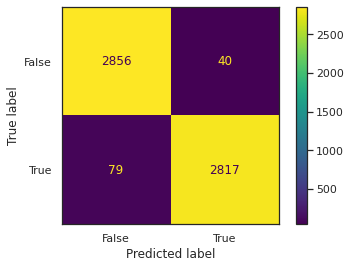

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, clf.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
len(gulp_data)

70

In [ ]:
len(y)

5792

In [ ]:
sum(y)

2896

In [ ]:
x.shape

(5792, 18)

In [ ]:
sum(clf.predict(x[:10]))

4

In [ ]:
import pickle

file_name = 'gulp_detection_model.sav'
pickle.dump(clf, open('gulp_detection_model.sav', 'wb'))

# New Section

# Tests

In [ ]:
int(len(gulp_data.loc[(gulp_data.audio == 's1') & (gulp_data.total_start_sec <= num_to_sec(start)) & (gulp_data.total_stop_sec >= num_to_sec(stop))]) > 0)

0

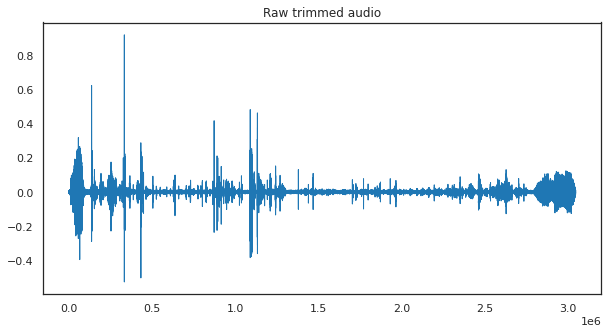

In [ ]:
y_trimmed, _ = librosa.effects.trim(y)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw = 1,
                  title ='Raw trimmed audio',
                  color = color_pal[0])
plt.show()

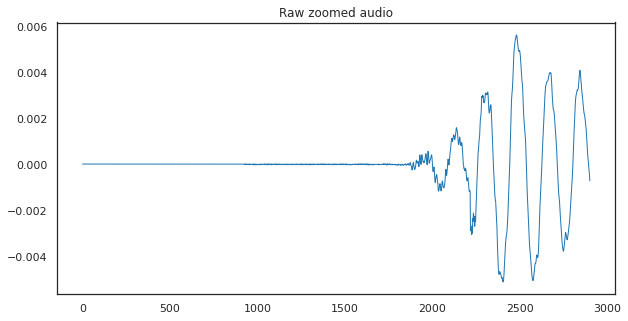

In [ ]:
pd.Series(y[100:3000]).plot(figsize=(10, 5),
                  lw = 1,
                  title ='Raw zoomed audio',
                  color = color_pal[0])
plt.show()

# Spectograph

In [ ]:
len(y) / sr

103.65392290249433

In [ ]:
4463.001953125 / (len(y) / sr)

43.05675876178153

In [ ]:
(len(y) - 1024) / 512 + 1

4463.001953125

In [ ]:
1024 / 2 + 1

513.0

In [ ]:
D = librosa.stft(y, n_fft=1024, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

In [ ]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db[:, int(7*43):int(10*43)],
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Melspectograph

In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128,)Q
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

ParameterError: ignored

In [ ]:
def time_to_num(minutes = 0, seconds = 0):
  return int(((minutes * 60) + seconds) * 44.44)

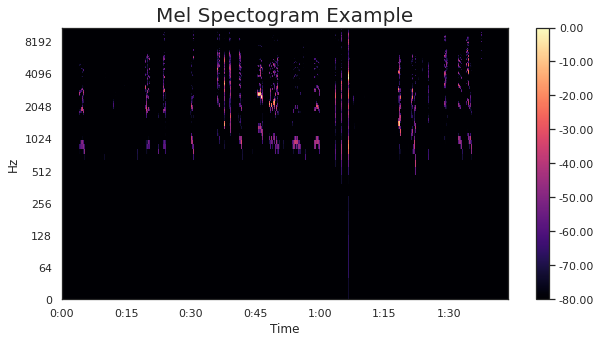

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel[:, :],
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

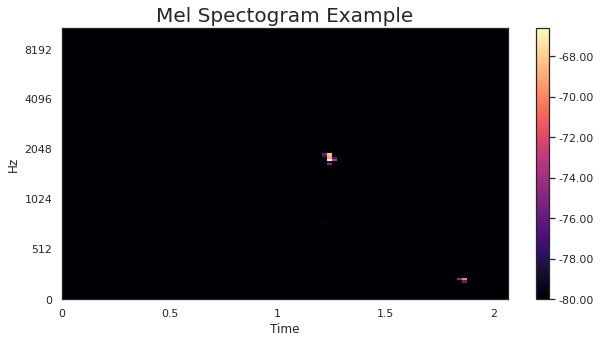

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel[:, time_to_num(seconds = 8):time_to_num(seconds = 10)],
                              x_axis='time',
                              y_axis='mel',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
S_db_mel.shape

(128, 4465)

# Mel Frequency Cepstral Coefficients

In [ ]:
mfccs = librosa.feature.mfcc(y, n_mfcc=13, sr=sr)

ParameterError: ignored

In [ ]:
mfccs.shape

NameError: ignored

NameError: ignored

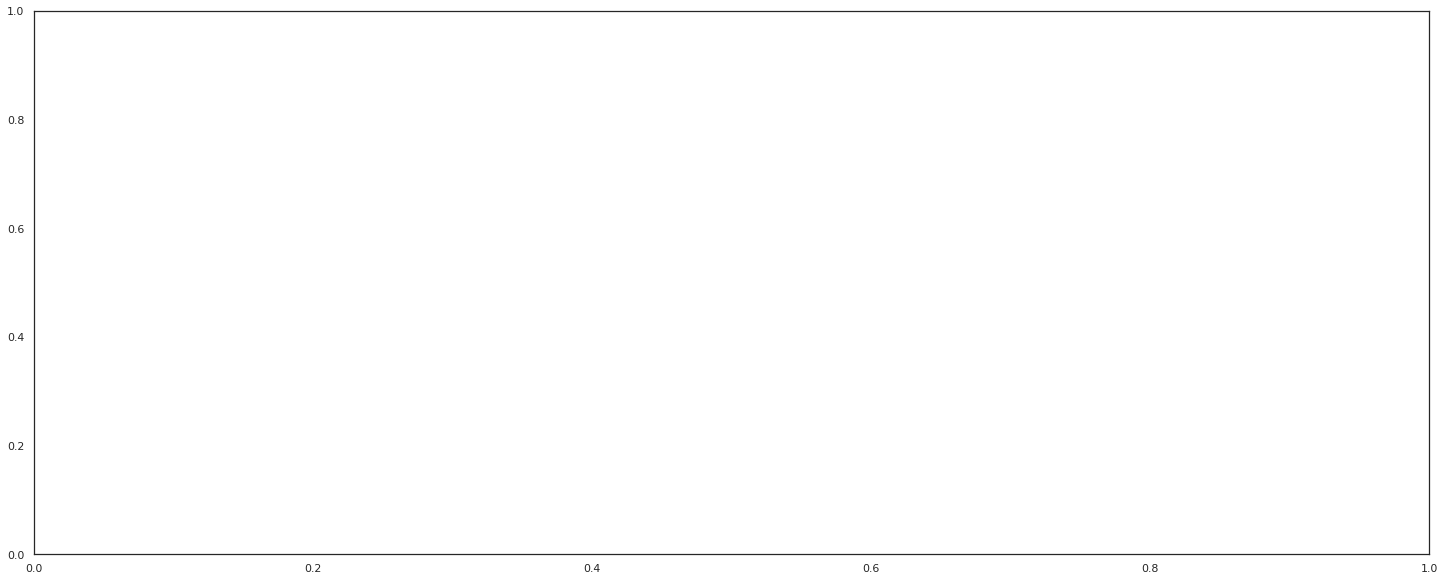

In [ ]:
fig, axis = plt.subplots(figsize=(25, 10))
img = librosa.display.specshow(mfccs,
                         x_axis="time",
                         ax=axis,
                         sr=sr)
axis.set_title('MFCCs', fontsize=20)
fig.colorbar(img, ax=axis, format=f'%0.2f')
plt.show()

NameError: ignored

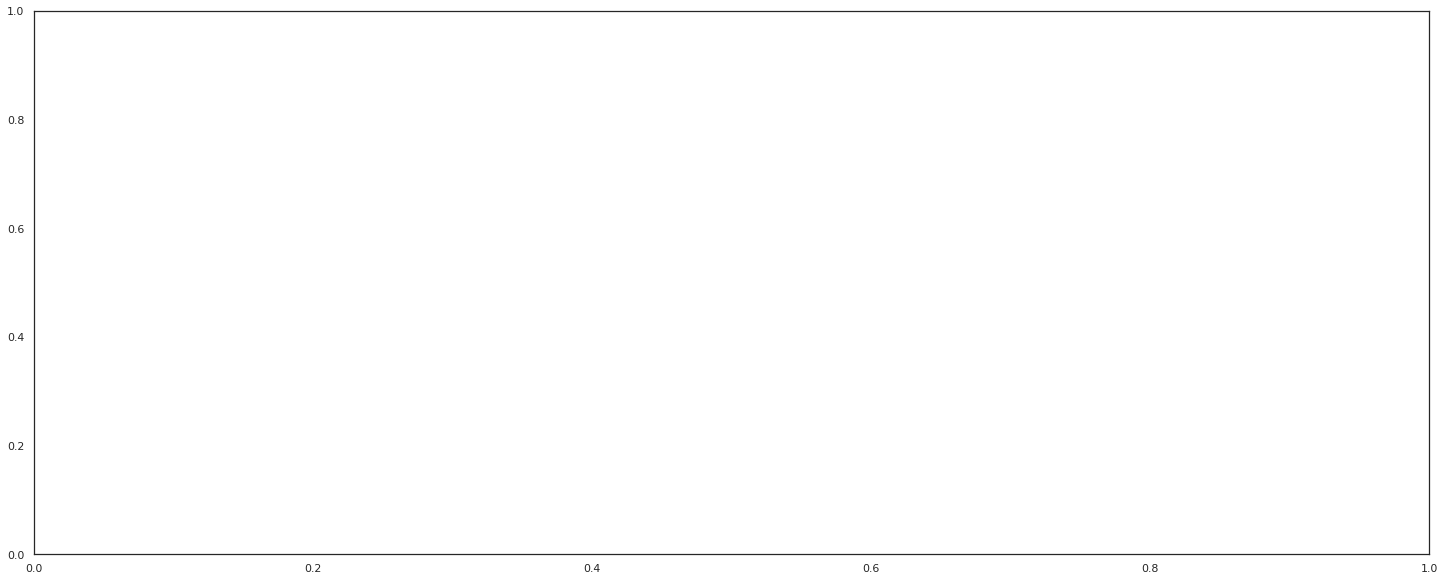

In [ ]:
fig, axis = plt.subplots(figsize=(25, 10))
img = librosa.display.specshow(mfccs[:, time_to_num(seconds = 8):time_to_num(seconds = 10)],
                         x_axis="time",
                         ax=axis,
                         sr=sr)

fig.colorbar(img, ax=axis, format=f'%0.2f')
plt.show()

## Delta and Delta2 MFCCs

In [ ]:
delta_mfccs = librosa.feature.delta(mfccs)
delta_mfccs_2 = librosa.feature.delta(mfccs, order=2)

NameError: ignored

In [ ]:
delta_mfccs.shape

NameError: ignored

In [ ]:
delta_mfccs_2.shape

NameError: ignored

In [ ]:
fig, axis = plt.subplots(figsize=(25, 10))
img = librosa.display.specshow(delta_mfccs,
                         x_axis="time",
                         ax=axis,
                         sr=sr)

axis.set_title('Delta MFCCs', fontsize=20)
fig.colorbar(img, ax=axis, format=f'%0.2f')
plt.show()

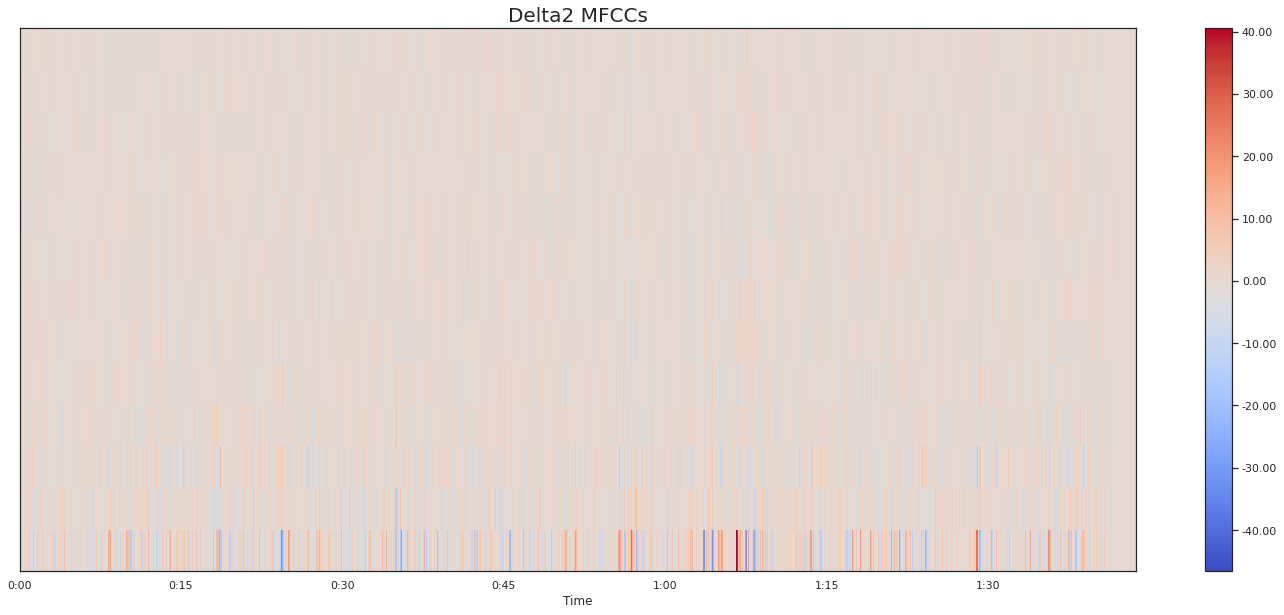

In [ ]:
fig, axis = plt.subplots(figsize=(25, 10))
img = librosa.display.specshow(delta_mfccs_2,
                         x_axis="time",
                         ax=axis,
                         sr=sr)

axis.set_title('Delta2 MFCCs', fontsize=20)
fig.colorbar(img, ax=axis, format=f'%0.2f')
plt.show()

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.Audio('s1 4.wav')

Output hidden; open in https://colab.research.google.com to view.

## Comprehensive MFCCs

In [ ]:
comprehansive_mfccs = np.concatenate((mfccs, delta_mfccs, delta_mfccs_2))

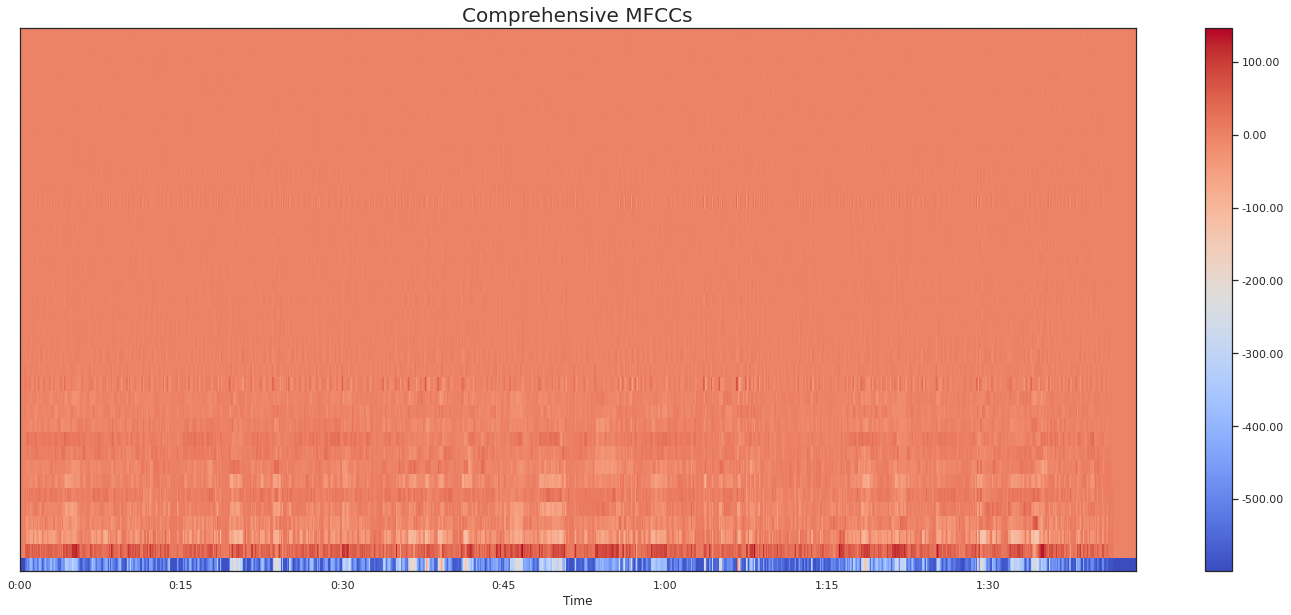

In [ ]:
fig, axis = plt.subplots(figsize=(25, 10))
img = librosa.display.specshow(comprehansive_mfccs,
                         x_axis="time",
                         ax=axis,
                         sr=sr)

axis.set_title('Comprehensive MFCCs', fontsize=20)
fig.colorbar(img, ax=axis, format=f'%0.2f')
plt.show()

# Applying GMM to comprehensive MFCCs

## Extracting Features

### LFCC implementation

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import librosa


def lin(sr, n_fft, n_filter=128, fmin=0.0, fmax=None, dtype=np.float32):

    if fmax is None:
        fmax = float(sr) / 2
    # Initialize the weights
    n_filter = int(n_filter)
    weights = np.zeros((n_filter, int(1 + n_fft // 2)), dtype=dtype)

    # Center freqs of each FFT bin
    fftfreqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of liner bands - uniformly spaced between limits
    linear_f = np.linspace(fmin, fmax, n_filter + 2)

    fdiff = np.diff(linear_f)
    ramps = np.subtract.outer(linear_f, fftfreqs)

    for i in range(n_filter):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i + 2] / fdiff[i + 1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    return weights


def linear_spec(y=None,
                sr=22050,
                n_fft=2048,
                hop_length=512,
                win_length=None,
                window='hann',
                center=True,
                pad_mode='reflect',
                power=2.0,
                **kwargs):
    S = np.abs(
        librosa.core.stft(y=y,
                          n_fft=n_fft,
                          hop_length=hop_length,
                          win_length=win_length,
                          window=window,
                          center=center,
                          pad_mode=pad_mode))**power
    filter = lin(sr=sr, n_fft=n_fft, **kwargs)
    return np.dot(filter, S)


def lfcc(y=None,
         sr=22050,
         S=None,
         n_lfcc=20,
         dct_type=2,
         norm='ortho',
         **kwargs):
    if S is None:
        S = librosa.power_to_db(linear_spec(y=y, sr=sr, **kwargs))
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_lfcc]
    return M

### Modelling

In [ ]:
frame_time = 16
frame_size = int(sr * frame_time / 1000)

overlap_per = 50
overlap_time = frame_time * overlap_per / 100
overlap = int(frame_size * overlap_per / 100)

print(f"Frame size: {frame_size}")
print(f"Frame time in milliseconds: {frame_time}ms")

print(f"Overlap time in milliseconds: {overlap_time}")
print(f"Overlap size: {overlap}")

Frame size: 656
Frame time in milliseconds: 16ms
Overlap time in milliseconds: 8.0
Overlap size: 328


In [ ]:
comprehensive_centroid = {}
comprehensive_mfccs = {}
comprehensive_lfccs = {}
comprehensive_zcr = {}
comprehensive_rf = {}

comprehensive_features = {}
for audio_signal in audio_signals.keys():
  # MFCCS
  mfccs = librosa.feature.mfcc(audio_signals[audio_signal], n_mfcc=13, sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_mfccs = librosa.feature.delta(mfccs)
  delta_mfccs_2 = librosa.feature.delta(mfccs, order=2)
  comprehensive_mfccs[audio_signal] = np.concatenate((mfccs, delta_mfccs, delta_mfccs_2))
  
  # LFCCS
  lfccs = lfcc(y=audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_lfccs = librosa.feature.delta(lfccs)
  delta_lfccs_2 = librosa.feature.delta(lfccs, order=2)
  comprehensive_lfccs[audio_signal] = np.concatenate((lfccs, delta_lfccs, delta_lfccs_2))

  # Zero Crossing Rate
  zcr = librosa.feature.zero_crossing_rate(audio_signals[audio_signal], frame_length=frame_size, hop_length=overlap)
  delta_zcr = librosa.feature.delta(zcr)
  delta_zcr_2 = librosa.feature.delta(zcr, order=2)
  comprehensive_zcr[audio_signal] = np.concatenate((zcr, delta_zcr, delta_zcr_2))

  # Roll off
  rf = librosa.feature.spectral_rolloff(audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_rf = librosa.feature.delta(rf)
  delta_rf_2 = librosa.feature.delta(rf, order=2)
  comprehensive_rf[audio_signal] = np.concatenate((rf, delta_rf, delta_rf_2))

  # Centroid
  centroid = librosa.feature.spectral_centroid(audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_centroid = librosa.feature.delta(centroid)
  delta_centroid_2 = librosa.feature.delta(centroid, order=2)
  comprehensive_centroid[audio_signal] = np.concatenate((centroid, delta_centroid, delta_centroid_2))

  # All Features
  comprehensive_features[audio_signal] = np.concatenate((mfccs, delta_mfccs, delta_mfccs_2,
                                           lfccs, delta_lfccs, delta_lfccs_2,
                                           zcr, delta_zcr, delta_zcr_2,
                                           rf, delta_rf, delta_rf_2,
                                           centroid, delta_centroid, delta_centroid_2))

comprehensive_features

{'s2': array([[-725.69335938, -725.69335938, -725.69335938, ..., -725.69335938,
         -725.69335938, -725.69335938],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [1174.93826176, 1174.93826176, 1174.93826176, ...,    0.        ,
            0.        ,    0.        ],
        [ 470.5258972 ,  470.5258972 ,  470.5258972 , ...,    0.        ,
            0.        ,    0.        ]]),
 's3': array([[-636.43615723, -636.43615723, -636.43615723, ..., -636.43615723,
         -636.43615723, -636.43615723],
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,   

In [ ]:
frames = np.concatenate((comprehensive_features['s1'], comprehensive_features['s2'], comprehensive_features['s3']), axis=1).T
frames.shape

(46147, 108)

In [ ]:
index = np.arange(len(frames))
np.random.shuffle(index)

test_ratio = 0.8

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

gmm = sklearn.mixture.GaussianMixture(n_components=2)
gmm.fit(frames[train_idx])

In [ ]:
gmm.score(frames[test_idx])

In [ ]:
gmm.converged_

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

X = frames

score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282:

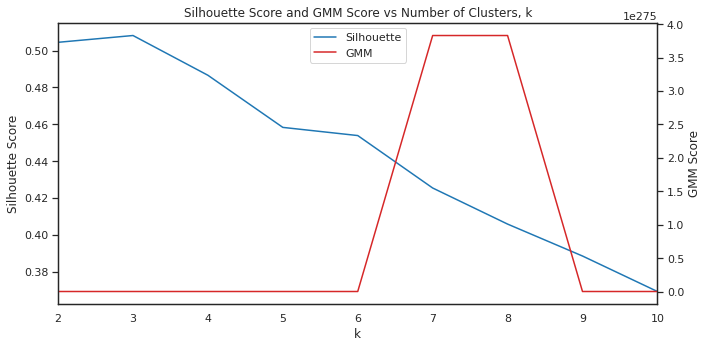

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

In [ ]:
import sklearn

gmm = sklearn.mixture.GaussianMixture(n_components=3)
gmm.fit(frames[train_idx])
print(np.exp(gmm.score_samples(frames[test_idx])).sum())
print(gmm.converged_)

8.120397834995188e+108
True


## Model Testing

In [ ]:
comprehensive_features['s1']

array([[-665.27911377, -665.27911377, -665.27911377, ..., -665.27911377,
        -665.27911377, -665.27911377],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [7964.48294626, 7749.62717135, 8062.83938897, ..., 6481.77086027,
        6214.66373486, 6422.0900277 ],
       [-372.02447178, -372.02447178, -372.02447178, ..., -141.17506897,
        -141.17506897, -141.17506897],
       [ -78.4941636 ,  -78.4941636 ,  -78.4941636 , ...,   73.20762498,
          73.20762498,   73.20762498]])

In [ ]:
(17353 * overlap) / sr

138.824

In [ ]:
cluster = []
file_name = []
gulp_constituency = []
num_zeroes = 0
frames_to_consider = []
for audio_file in comprehensive_features.keys():
    for idx, frame in tqdm(enumerate(comprehensive_features[audio_file].T)):
        gulp_presence = int(len(gulp_data.loc[(gulp_data.audio == audio_file) & (gulp_data.total_start_sec <= (idx * overlap / sr)) & (gulp_data.total_stop_sec >= ((idx + 1) * overlap / sr))]) > 0)
        num_zeroes += (gulp_presence == 0)
        if num_zeroes > 2896 and (gulp_presence == 0): continue
        gulp_constituency.append(gulp_presence)
        cluster.append(gmm.predict(frame.reshape(1, -1))[0])
        file_name.append(audio_file)
        frames_to_consider.append(frame)
frames_to_consider = np.array(frames_to_consider)
frames_to_consider.shape

18623it [00:20, 894.12it/s] 
13587it [00:12, 1058.62it/s]
13937it [00:12, 1075.34it/s]


(5853, 108)

In [ ]:
predictions = pd.DataFrame()
predictions['cluster'] = cluster
predictions['file_name'] = file_name
predictions['gulp_constituency'] = gulp_constituency
predictions.describe()

cluster  gulp_constituency
count  5853.000000        5853.000000
mean      1.449171           0.505211
std       0.643880           0.500016
min       0.000000           0.000000
25%       1.000000           0.000000
50%       2.000000           1.000000
75%       2.000000           1.000000
max       2.000000           1.000000

In [ ]:
predictions.groupby(['gulp_constituency']).count()

cluster  file_name
gulp_constituency                    
0                     2896       2896
1                     2957       2957

In [ ]:
predictions.groupby(['gulp_constituency', 'cluster']).count()

file_name
gulp_constituency cluster           
0                 0               73
                  1              907
                  2             1916
1                 0              416
                  1             1339
                  2             1202

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

X = frames_to_consider

score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282:

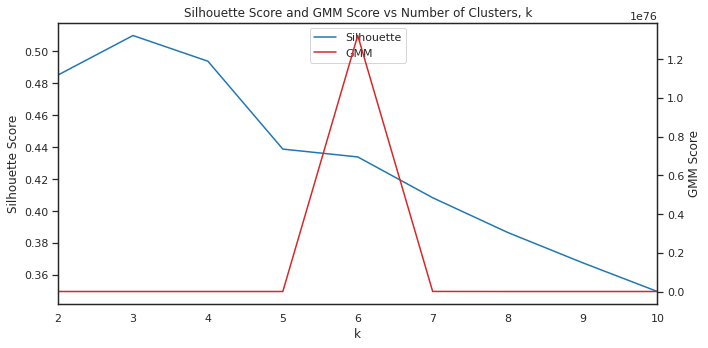

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

In [ ]:
index = np.arange(len(frames_to_consider))
np.random.shuffle(index)

test_ratio = 0.9

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

gmm = sklearn.mixture.GaussianMixture(n_components=3)
gmm.fit(frames_to_consider[train_idx])
print(np.exp(gmm.score_samples(frames_to_consider[test_idx])).sum())
print(gmm.converged_)

30.124774113939225
True


In [ ]:
frames_to_consider.shape

(5853, 108)

In [ ]:
cluster = []
file_name = []
gulp_constituency = []
num_zeroes = 0
frames_to_consider = []
time_frame = []
for audio_file in comprehensive_features.keys():
    for idx, frame in tqdm(enumerate(comprehensive_features[audio_file].T)):
        gulp_presence = int(len(gulp_data.loc[(gulp_data.audio == audio_file) & (gulp_data.total_start_sec <= (idx * overlap / sr)) & (gulp_data.total_stop_sec >= ((idx + 1) * overlap / sr))]) > 0)
        num_zeroes += (gulp_presence == 0)
        if num_zeroes > 2896 and (gulp_presence == 0): continue
        gulp_constituency.append(gulp_presence)
        cluster.append(gmm.predict(frame.reshape(1, -1))[0])
        file_name.append(audio_file)
        frames_to_consider.append(frame)
        time_frame.append((idx * overlap / sr))
frames_to_consider = np.array(frames_to_consider)
frames_to_consider.shape

18623it [00:20, 915.00it/s] 
13587it [00:13, 1041.26it/s]
13937it [00:13, 1026.45it/s]


(5853, 108)

In [ ]:
predictions = pd.DataFrame()
predictions['cluster'] = cluster
predictions['file_name'] = file_name
predictions['gulp_constituency'] = gulp_constituency
predictions['total_start_sec'] = time_frame
predictions.describe()

cluster  gulp_constituency  total_start_sec
count  5853.000000        5853.000000      5853.000000
mean      0.195284           0.505211        32.336422
std       0.507933           0.500016        30.731585
min       0.000000           0.000000         0.000000
25%       0.000000           0.000000        10.624000
50%       0.000000           1.000000        19.744000
75%       0.000000           1.000000        47.304000
max       2.000000           1.000000       122.936000

In [ ]:
predictions

cluster file_name  gulp_constituency  total_start_sec
0           0        s2                  0            0.000
1           0        s2                  0            0.008
2           0        s2                  0            0.016
3           0        s2                  0            0.024
4           0        s2                  0            0.032
...       ...       ...                ...              ...
5848        0        s1                  1           95.760
5849        0        s1                  1           95.768
5850        0        s1                  1           95.776
5851        0        s1                  1           95.784
5852        0        s1                  1           95.792

[5853 rows x 4 columns]

In [ ]:
start_time = 0
positives = {'s1': [],
             's2': [],
             's3': []}
for file_name in positives.keys():
  start_time = 0
  for idx, row in predictions.loc[(predictions.file_name == file_name) & (predictions.cluster == 1)].iterrows():
    if start_time == 0: start_time = row.total_start_sec
    if (row.total_start_sec - start_time) > 1:
      positives[file_name].append((start_time, row.total_start_sec))
      start_time = row.total_start_sec

In [ ]:
positives

{'s1': [(64.344, 84.328)],
 's2': [(0.112, 1.12),
  (1.12, 2.176),
  (2.176, 3.184),
  (3.184, 4.192),
  (4.192, 5.848),
  (5.848, 7.368),
  (7.368, 9.016),
  (9.016, 10.024),
  (10.024, 11.656),
  (11.656, 12.664),
  (12.664, 13.68),
  (13.68, 16.392),
  (16.392, 17.472),
  (17.472, 20.216),
  (20.216, 21.4),
  (21.4, 28.584),
  (28.584, 66.68)],
 's3': [(15.776, 25.44),
  (25.44, 43.384),
  (43.384, 56.328),
  (56.328, 60.456),
  (60.456, 78.976),
  (78.976, 81.928),
  (81.928, 85.304)]}

In [ ]:
predictions.groupby('gulp_constituency').count()

cluster  file_name  total_start_sec
gulp_constituency                                     
0                     2896       2896             2896
1                     2957       2957             2957

In [ ]:
predictions.groupby(['gulp_constituency', 'cluster']).count()

file_name  total_start_sec
gulp_constituency cluster                            
0                 0             2405             2405
                  1              459              459
                  2               32               32
1                 0             2600             2600
                  1               94               94
                  2              263              263

In [ ]:
predictions.groupby(['file_name', 'gulp_constituency', 'cluster']).count()

total_start_sec
file_name gulp_constituency cluster                 
s1        1                 0                    573
                            1                     10
                            2                    119
s2        0                 0                   2405
                            1                    459
                            2                     32
          1                 0                   1290
                            1                     18
                            2                     13
s3        1                 0                    737
                            1                     66
                            2                    131

In [ ]:
predictions.groupby(['file_name', 'cluster']).count().total_start_sec

file_name  cluster
s1         0           573
           1            10
           2           119
s2         0          3695
           1           477
           2            45
s3         0           737
           1            66
           2           131
Name: total_start_sec, dtype: int64

In [ ]:
predictions.cluster.unique()

array([0, 2, 1])

In [ ]:
predictions.loc[(predictions.cluster == 1) | (predictions.cluster == 2)]

cluster file_name  gulp_constituency  total_start_sec
10          2        s2                  0            0.080
11          2        s2                  0            0.088
14          1        s2                  0            0.112
15          1        s2                  0            0.120
16          1        s2                  0            0.128
...       ...       ...                ...              ...
5783        2        s1                  1           77.088
5784        2        s1                  1           77.096
5786        2        s1                  1           77.112
5797        2        s1                  1           82.984
5833        1        s1                  1           84.328

[848 rows x 4 columns]

In [ ]:
predictions.groupby('cluster').count()

file_name  gulp_constituency  total_start_sec
cluster                                               
0             5005               5005             5005
1              553                553              553
2              295                295              295

# Additional tests

Please provide audio file name: /content/1_20230122084447_1206_SDR_1_gulp_segs.wav



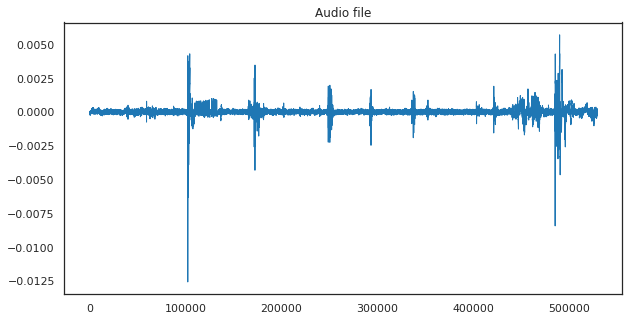

Processing audio signal file: /content/1_20230122084447_1206_SDR_1_gulp_segs.wav


Number of gulps: 1.0
Amount of liquid consumed: 4.8ml


In [ ]:
import pickle
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
from scipy import signal
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

sr: int = 44100
def gulp_to_volume(num_gupls: int) -> float:
    return (random.randint(10, 50) * 0.1 * num_gupls);

def num_to_sec(num: int) -> float:
  return num / sr

# audio_to_process: str = 's3 3.wav'
audio_to_process: str = input("Please provide audio file name: ")
print()

audio, sr = librosa.load(audio_to_process, sr=sr)

pd.Series(audio).plot(figsize=(10, 5),
                  lw = 1,
                  title ='Audio file',
                  color = color_pal[0])
plt.show()

from scipy.fft import fft, fftfreq
from scipy import signal


frame_time = 16
frame_size = int(sr * frame_time / 1000)

overlap_per = 50
overlap_time = frame_time * overlap_per / 100
overlap = int(frame_size * overlap_per / 100)

# print(f"Frame size: {frame_size}")
# print(f"Frame time in milliseconds: {frame_time}ms")
# 
# print(f"Overlap time in milliseconds: {overlap_time}")
# print(f"Overlap size: {overlap}")

# Statistical Features- time
time_frame_data_mins = []
time_frame_data_maxs = []
time_frame_data_means = []
time_frame_data_medians = []
time_frame_data_stds = []
time_frame_data_ptps = []

# Time domain features
amplitude_evelopes = []
root_mean_square_energies = []
zero_crossing_rates = []

# Statistical Features- freq
freq_magnitude_prod_frame_data_mins = []
freq_magnitude_prod_frame_data_maxs = []
freq_magnitude_prod_frame_data_means = []
freq_magnitude_prod_frame_data_medians = []
freq_magnitude_prod_frame_data_stds = []
freq_magnitude_prod_frame_data_ptps = []

# Frequency domain features
split_frequency = 1500
band_energy_ratios = []
spectral_centroids = []
bandwidths = []

# Gulp Data
gulp_constituencies = []

# Audio Metadata
audio_name = []

print(f'Processing audio signal file: {audio_to_process}')
y = audio
for start in (range(0, len(y), overlap)):

    # Getting Frame
    stop = (start + frame_size) if (start + frame_size) < len(y) else (len(y) - 1)
    time_frame_data = y[start:stop]
    if (stop - start) < overlap: break

    # Time based Statistical Features
    time_frame_data_mins.append(np.amin(time_frame_data))
    time_frame_data_maxs.append(np.amax(time_frame_data))
    time_frame_data_means.append(np.mean(time_frame_data))
    time_frame_data_medians.append(np.median(time_frame_data))
    time_frame_data_stds.append(np.std(time_frame_data))
    time_frame_data_ptps.append(np.ptp(time_frame_data))

    # Time domain features
    amplitude_evelopes.append(np.amax(time_frame_data))
    root_mean_square_energies.append(np.sqrt(np.mean(time_frame_data**2)))
    zero_crossing_rates.append(0.5 * np.sum([np.abs(np.sign(time_frame_data[idx]) - np.sign(time_frame_data[idx + 1])) for idx in range(len(time_frame_data) - 1)]))

    # Fourier transform with hann windowing
    N = (len(time_frame_data))
    yf = np.abs(np.fft.fft(signal.hann(N) * time_frame_data)) [:N//2]
    xf = np.linspace(0, sr, N)[:N//2]

    # Frequency based Statistical Features
    freq_magnitude_prod_frame_data = xf * yf
    freq_magnitude_prod_frame_data_mins.append(np.amin(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_maxs.append(np.amax(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_means.append(np.mean(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_medians.append(np.median(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_stds.append(np.std(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_ptps.append(np.ptp(freq_magnitude_prod_frame_data))

    # Frequency domain features
    temp = np.sum(yf[int(split_frequency* (N / sr)):] ** 2)
    if temp == 0 or np.sum(yf) == 0: 
        band_energy_ratios.append(0)
        spectral_centroids.append(0)
        bandwidths.append(0)
    else: 
        band_energy_ratios.append(np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / temp)
        spectral_centroids.append(np.sum(yf * xf) / np.sum(yf))
        bandwidths.append(np.sum((xf - (np.sum(yf * xf) / np.sum(yf))) * yf) / np.sum(yf))

    # Gulp Data

    # Audio Metadata
    audio_name.append(audio_to_process)

# Dataframe initialization
gulp_analysis = pd.DataFrame()

# Statistical Features- time
gulp_analysis['time_frame_data_mins'] = time_frame_data_mins
gulp_analysis['time_frame_data_maxs'] = time_frame_data_maxs
gulp_analysis['time_frame_data_means'] = time_frame_data_means
gulp_analysis['time_frame_data_medians'] = time_frame_data_medians
gulp_analysis['time_frame_data_stds'] = time_frame_data_stds
gulp_analysis['time_frame_data_ptps'] = time_frame_data_ptps

# Time domain features
gulp_analysis['amplitude_evelopes'] = amplitude_evelopes
gulp_analysis['root_mean_square_energies'] = root_mean_square_energies
gulp_analysis['zero_crossing_rates'] = zero_crossing_rates

# Statistical Features- freq
gulp_analysis['freq_magnitude_prod_frame_data_mins'] = freq_magnitude_prod_frame_data_mins
gulp_analysis['freq_magnitude_prod_frame_data_maxs'] = freq_magnitude_prod_frame_data_maxs
gulp_analysis['freq_magnitude_prod_frame_data_means'] = freq_magnitude_prod_frame_data_means
gulp_analysis['freq_magnitude_prod_frame_data_medians'] = freq_magnitude_prod_frame_data_medians
gulp_analysis['freq_magnitude_prod_frame_data_stds'] = freq_magnitude_prod_frame_data_stds
gulp_analysis['freq_magnitude_prod_frame_data_ptps'] = freq_magnitude_prod_frame_data_ptps

# Frequency domain features
gulp_analysis['band_energy_ratios'] = band_energy_ratios
gulp_analysis['spectral_centroids'] = spectral_centroids
gulp_analysis['bandwidths'] = bandwidths


# Audio Metadata
gulp_analysis['audio_name'] = audio_name

x = gulp_analysis.drop(['audio_name'], axis=1).dropna().values

clf = pickle.load(open('gulp_detection_model.sav', 'rb'))
num_of_gulps: int = np.ceil(sum(clf.predict(x)) / 144)
volume_of_liquid_consumed: float = gulp_to_volume(num_of_gulps)

print(f"\n\nNumber of gulps: {num_of_gulps}")
print(f"Amount of liquid consumed: {round(volume_of_liquid_consumed, 2)}ml")

# pd.Series(audio).plot(figsize=(10, 5),
#                   lw = 1,
#                   title ='Audio file',
#                   color = color_pal[0])
# plt.show()

Please provide audio file name: s1 4.wav



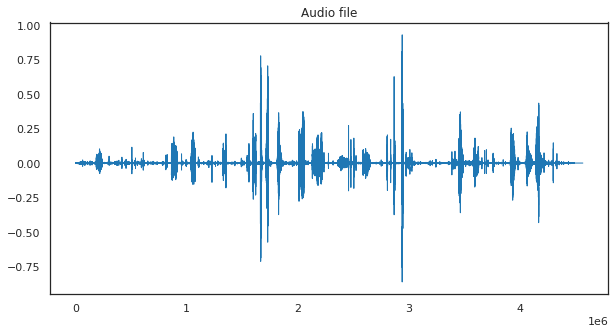

Processing audio signal file: s1 4.wav


Number of gulps: 81
Amount of liquid consumed: 162.0ml


In [ ]:
import pickle
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm
from scipy.fft import fft, fftfreq
from scipy import signal
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

sr: int = 44100
def gulp_to_volume(num_gupls: int) -> float:
    return (random.randint(10, 50) * 0.1 * num_gupls);

def num_to_sec(num: int) -> float:
  return num / sr

# audio_to_process: str = 's3 3.wav'
audio_to_process: str = input("Please provide audio file name: ")
print()

audio, sr = librosa.load(audio_to_process, sr=sr)

pd.Series(audio).plot(figsize=(10, 5),
                  lw = 1,
                  title ='Audio file',
                  color = color_pal[0])
plt.show()

from scipy.fft import fft, fftfreq
from scipy import signal


frame_time = 16
frame_size = int(sr * frame_time / 1000)

overlap_per = 50
overlap_time = frame_time * overlap_per / 100
overlap = int(frame_size * overlap_per / 100)

# print(f"Frame size: {frame_size}")
# print(f"Frame time in milliseconds: {frame_time}ms")
# 
# print(f"Overlap time in milliseconds: {overlap_time}")
# print(f"Overlap size: {overlap}")

# Statistical Features- time
time_frame_data_mins = []
time_frame_data_maxs = []
time_frame_data_means = []
time_frame_data_medians = []
time_frame_data_stds = []
time_frame_data_ptps = []

# Time domain features
amplitude_evelopes = []
root_mean_square_energies = []
zero_crossing_rates = []

# Statistical Features- freq
freq_magnitude_prod_frame_data_mins = []
freq_magnitude_prod_frame_data_maxs = []
freq_magnitude_prod_frame_data_means = []
freq_magnitude_prod_frame_data_medians = []
freq_magnitude_prod_frame_data_stds = []
freq_magnitude_prod_frame_data_ptps = []

# Frequency domain features
split_frequency = 1500
band_energy_ratios = []
spectral_centroids = []
bandwidths = []

# Gulp Data
gulp_constituencies = []

# Audio Metadata
audio_name = []

print(f'Processing audio signal file: {audio_to_process}')
y = audio
for start in (range(0, len(y), overlap)):

    # Getting Frame
    stop = (start + frame_size) if (start + frame_size) < len(y) else (len(y) - 1)
    time_frame_data = y[start:stop]
    if (stop - start) < overlap: break

    # Time based Statistical Features
    time_frame_data_mins.append(np.amin(time_frame_data))
    time_frame_data_maxs.append(np.amax(time_frame_data))
    time_frame_data_means.append(np.mean(time_frame_data))
    time_frame_data_medians.append(np.median(time_frame_data))
    time_frame_data_stds.append(np.std(time_frame_data))
    time_frame_data_ptps.append(np.ptp(time_frame_data))

    # Time domain features
    amplitude_evelopes.append(np.amax(time_frame_data))
    root_mean_square_energies.append(np.sqrt(np.mean(time_frame_data**2)))
    zero_crossing_rates.append(0.5 * np.sum([np.abs(np.sign(time_frame_data[idx]) - np.sign(time_frame_data[idx + 1])) for idx in range(len(time_frame_data) - 1)]))

    # Fourier transform with hann windowing
    N = (len(time_frame_data))
    yf = np.abs(np.fft.fft(signal.hann(N) * time_frame_data)) [:N//2]
    xf = np.linspace(0, sr, N)[:N//2]

    # Frequency based Statistical Features
    freq_magnitude_prod_frame_data = xf * yf
    freq_magnitude_prod_frame_data_mins.append(np.amin(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_maxs.append(np.amax(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_means.append(np.mean(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_medians.append(np.median(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_stds.append(np.std(freq_magnitude_prod_frame_data))
    freq_magnitude_prod_frame_data_ptps.append(np.ptp(freq_magnitude_prod_frame_data))

    # Frequency domain features
    temp = np.sum(yf[int(split_frequency* (N / sr)):] ** 2)
    if temp == 0 or np.sum(yf) == 0: 
        band_energy_ratios.append(0)
        spectral_centroids.append(0)
        bandwidths.append(0)
    else: 
        band_energy_ratios.append(np.sum(yf[:int(split_frequency* (N / sr))] ** 2) / temp)
        spectral_centroids.append(np.sum(yf * xf) / np.sum(yf))
        bandwidths.append(np.sum((xf - (np.sum(yf * xf) / np.sum(yf))) * yf) / np.sum(yf))

    # Gulp Data

    # Audio Metadata
    audio_name.append(audio_to_process)

# Dataframe initialization
gulp_analysis = pd.DataFrame()

# Statistical Features- time
gulp_analysis['time_frame_data_mins'] = time_frame_data_mins
gulp_analysis['time_frame_data_maxs'] = time_frame_data_maxs
gulp_analysis['time_frame_data_means'] = time_frame_data_means
gulp_analysis['time_frame_data_medians'] = time_frame_data_medians
gulp_analysis['time_frame_data_stds'] = time_frame_data_stds
gulp_analysis['time_frame_data_ptps'] = time_frame_data_ptps

# Time domain features
gulp_analysis['amplitude_evelopes'] = amplitude_evelopes
gulp_analysis['root_mean_square_energies'] = root_mean_square_energies
gulp_analysis['zero_crossing_rates'] = zero_crossing_rates

# Statistical Features- freq
gulp_analysis['freq_magnitude_prod_frame_data_mins'] = freq_magnitude_prod_frame_data_mins
gulp_analysis['freq_magnitude_prod_frame_data_maxs'] = freq_magnitude_prod_frame_data_maxs
gulp_analysis['freq_magnitude_prod_frame_data_means'] = freq_magnitude_prod_frame_data_means
gulp_analysis['freq_magnitude_prod_frame_data_medians'] = freq_magnitude_prod_frame_data_medians
gulp_analysis['freq_magnitude_prod_frame_data_stds'] = freq_magnitude_prod_frame_data_stds
gulp_analysis['freq_magnitude_prod_frame_data_ptps'] = freq_magnitude_prod_frame_data_ptps

# Frequency domain features
gulp_analysis['band_energy_ratios'] = band_energy_ratios
gulp_analysis['spectral_centroids'] = spectral_centroids
gulp_analysis['bandwidths'] = bandwidths


# Audio Metadata
gulp_analysis['audio_name'] = audio_name

x = gulp_analysis.drop(['audio_name'], axis=1).dropna().values

clf = pickle.load(open('gulp_detection_model.sav', 'rb'))
num_of_gulps: int = int(sum(clf.predict(x)) / 144)
volume_of_liquid_consumed: float = gulp_to_volume(num_of_gulps)

print(f"\n\nNumber of gulps: {num_of_gulps}")
print(f"Amount of liquid consumed: {round(volume_of_liquid_consumed, 2)}ml")

# pd.Series(audio).plot(figsize=(10, 5),
#                   lw = 1,
#                   title ='Audio file',
#                   color = color_pal[0])
# plt.show()


# Accelerometer Issue